In [29]:
import os
import argparse
import tensorflow as tf
from IPython import display
from tensorflow import Tensor
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import numpy as np

from PIL import Image

import utils  # local import
from model import Generator  # local import
from tqdm import tqdm


In [30]:
EPOCHS = 100
LAMBDA = 100
BATCH_SIZE = 8
IMG_WIDTH = 1024
IMG_HEIGHT = 413
BUFFER_SIZE = 400
SAVE_PATH = 'weights'
  # Custom dataset name
ff_dim = 32
num_heads = 2
patch_size = 8
embed_dim = 64
projection_dim = 64
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
num_patches = (IMG_HEIGHT // patch_size) ** 2

In [31]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [32]:
device = '/device:GPU:0' if utils.check_cuda else '/cpu:0'
device

'/device:GPU:0'

In [ ]:
dataset_name = 'erosion_dilatacion'
env_path = '..'

In [34]:
dataset_path = f"{env_path}/{dataset_name}"

In [35]:
def load(image_file):
    # Leer y decodificar la imagen como un tensor uint8 con un canal (escala de grises)
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image, channels=1)

    # Obtener la mitad de la anchura para dividir la imagen
    w = tf.shape(image)[1]
    w = w // 2

    # Dividir la imagen en dos partes: entrada y real
    input_image = image[:, w:, :]  # Parte derecha
    real_image = image[:, :w, :]   # Parte izquierda

    # Convertir ambas imágenes a tensores float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

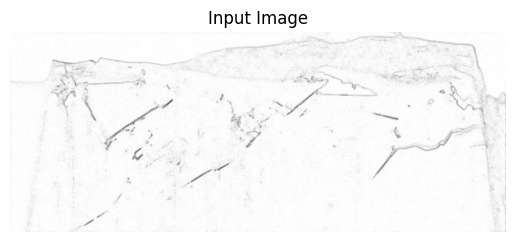

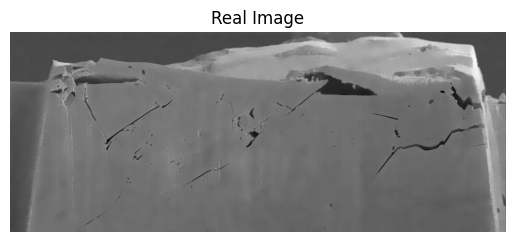

In [36]:
inp, re = load(str(f'{dataset_path}/train/SEM Imaging_ETD-SE_q1_x01_y01_s0004.png'))
# Casting to int for matplotlib to display the images
inp = inp / 255.0
re = re / 255.0


# Visualizar la imagen de entrada
plt.figure()
plt.title("Input Image")
plt.imshow(tf.squeeze(inp), cmap='gray')  # tf.squeeze elimina la dimensión del canal
plt.axis('off')

# Visualizar la imagen real
plt.figure()
plt.title("Real Image")
plt.imshow(tf.squeeze(re), cmap='gray')  # tf.squeeze elimina la dimensión del canal
plt.axis('off')

plt.show()

In [37]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [38]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]

In [39]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [40]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, int(IMG_HEIGHT*1.5),int(IMG_WIDTH*1.5))

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [41]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [42]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [43]:
train_dataset = tf.data.Dataset.list_files(f'{dataset_path}/train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [44]:
try:
  test_dataset = tf.data.Dataset.list_files(str(f'{dataset_path}/test/*.png'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(f'{dataset_path}/test/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [45]:
OUTPUT_CHANNELS = 1

In [46]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 413, 1024, 1)]       0         []                            
                                                                                                  
 patches_1 (Patches)         (None, None, 256)            0         ['input_2[0][0]']             
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 1664, 256)            491776    ['patches_1[0][0]']           
 der)                                                                                             
                                                                                                  
 transformer_block_4 (Trans  (None, 1664, 256)            1315840   ['patch_encoder_1[0][0]'

In [47]:
# generator.load_weights('/teamspace/studios/this_studio/tensor-to-image/src/models/erosion_dilatacion_100_VT.h5')

In [ ]:
def save_prediction(prediction, dataset_name, filename='prediction.png'):
    """
    Guarda una predicción como imagen en escala de grises con dimensiones exactas.
    
    Parameters:
        prediction (tf.Tensor or np.ndarray): Tensor de predicción con dimensiones (1, H, W, 1).
        filename (str): Nombre del archivo de salida.
    """
    # Convertir a numpy si es un tensor de TensorFlow
    if isinstance(prediction, tf.Tensor):
        prediction = prediction.numpy()
    
    # Eliminar dimensiones adicionales (1, H, W, 1) -> (H, W)
    if prediction.ndim == 4 and prediction.shape[0] == 1:
        prediction = np.squeeze(prediction, axis=(0, -1))  # (H, W)
    elif prediction.ndim != 2:
        raise ValueError("Las dimensiones de entrada deben ser (1, H, W, 1) o (H, W).")
    
    # Escalar valores a [0, 1] si están en el rango [-1, 1]
    if prediction.min() < 0 or prediction.max() > 1:
        prediction = (prediction + 1) / 2.0  # Escalado de [-1, 1] a [0, 1]

    # Clip valores para garantizar que estén dentro de [0, 1]
    prediction = np.clip(prediction, 0, 1)

    # Convertir a escala de 0-255 para guardar como imagen
    prediction = (prediction * 255).astype(np.uint8)

    # Guardar la imagen usando PIL para conservar dimensiones
    img = Image.fromarray(prediction, mode='L')  # Escala de grises
    img.save(f'{env_path}/resultados/{dataset_name}/{filename}')
    print(f'Imagen {filename} guardada')

In [49]:
def generate_images(model, test_input, tar, epoch=0, name='',dataset_name='', final=False):
  prediction = model(test_input, training=True)
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  plt.figure(figsize=(15,6))

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    plt.axis('off')


  # if epoch % 5000 == 0:
  #   plt.savefig(f'{imagenes_d}_imagenes/epoch_{epoch}.jpg')
  #   plt.show()

  if final:
    save_prediction(prediction,dataset_name, name)

In [50]:
def generate_batch_images(model, test_input, tar):
    for i in range(len(test_input)):
        prediction = model(test_input, training=True)
        plt.figure(figsize=(15, 15))

        display_list = [test_input[i], tar[i], prediction[i]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # converting the pixel values to [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [57]:
def evaluate_model(generator, test_dataset, save_dir=None):
    psnr_values = []
    ssim_values = []

    for idx, (input_batch, target_batch) in enumerate(tqdm(test_dataset)):
        # Realiza predicción por batch
        prediction_batch = generator(input_batch, training=False)

        # Recorre cada imagen del batch
        for i in range(prediction_batch.shape[0]):
            pred = prediction_batch[i]
            tgt = target_batch[i]

            psnr = tf.image.psnr(tgt, pred, max_val=1.0).numpy()
            ssim = tf.image.ssim(tgt, pred, max_val=1.0).numpy()

            psnr_values.append(psnr)
            ssim_values.append(ssim)

            if save_dir:
                # Asegura el formato correcto para guardar
                pred_img = tf.image.convert_image_dtype(pred, dtype=tf.uint8)
                pred_img_path = os.path.join(save_dir, f"epoch_pred_{idx}_{i}.png")
                tf.keras.utils.save_img(pred_img_path, pred_img)

    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)

    return mean_psnr, mean_ssim

In [63]:
def train_step(input_image, target, epoch):
    with tf.device(device):
        with tf.GradientTape() as gen_tape:
            gen_output = generator(input_image, training=True)

            gen_total_loss = tf.reduce_mean(tf.abs(target - gen_output))

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)

        optimizer.apply_gradients(zip(generator_gradients,
                                      generator.trainable_variables))


def fit(train_ds, epochs, test_ds):
    best_score = -1
    print(f"[INFO] will train on device: {device}")
    for epoch in range(epochs):

        if utils.is_notebook():
            display.clear_output(wait=True)

            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)

        print(f'Epoch: [{epoch}/{epochs}]')

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            train_step(input_image, target, epoch)

        # generator.save_weights(f'{env_path}/{dataset_name}_weights/tensor2image-{epoch}-epochs-weights.h5')
        psnr, ssim = evaluate_model(generator, test_dataset)
        current_score = psnr + ssim

        print(f"Evaluation -> PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")

        if current_score > best_score:
            best_score = current_score
            generator.save_weights(os.path.join(SAVE_PATH, f"{dataset_name}_best_generator_weights.h5"))
            print("✅ Mejores pesos guardados.")


def test(test_dataset, generator):
    ''' 
    a function to visually inspect to outputs
    '''
    if utils.is_notebook():
        for inp, tar in test_dataset.take(1):
            generate_batch_images(generator, inp, tar)

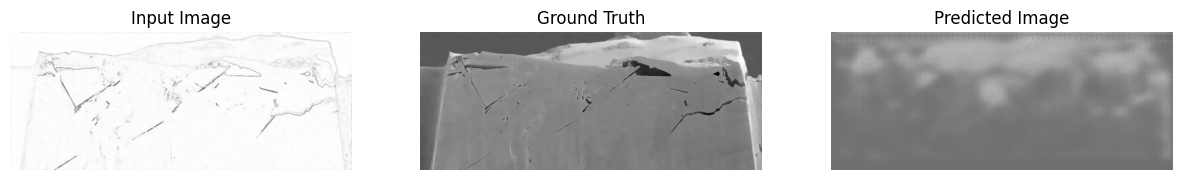

In [64]:
for example_input, example_target in test_dataset.take(1):
  # print(example_input.shape)
  generate_images(generator, example_input, example_target)

In [65]:
def generate_image_metrics(generator, test_input, tar):
    # Generar la predicción
    prediction = generator(test_input, training=False)

    # Convertir tensores de TF a numpy arrays
    tar = tar.numpy()
    prediction = prediction.numpy()
    
    # Escalar de [-1, 1] a [0, 255] y convertir a uint8
    tar = ((tar + 1) * 127.5).astype(np.uint8)
    prediction = ((prediction + 1) * 127.5).astype(np.uint8)

    # Si la imagen tiene un canal extra (ej. forma (H, W, 1)), se elimina para obtener (H, W)
    if tar.ndim == 3 and tar.shape[-1] == 1:
        tar = np.squeeze(tar, axis=-1)
    if prediction.ndim == 3 and prediction.shape[-1] == 1:
        prediction = np.squeeze(prediction, axis=-1)

    # Convertir a tensores de tipo float32 para TensorFlow
    tar_tensor = tf.convert_to_tensor(tar, dtype=tf.float32)
    pred_tensor = tf.convert_to_tensor(prediction, dtype=tf.float32)

    # Calcular PSNR y SSIM usando las funciones de TensorFlow
    psnr_value = tf.image.psnr(tar_tensor, pred_tensor, max_val=255).numpy()
    ssim_value = tf.image.ssim(tar_tensor, pred_tensor, max_val=255).numpy()

    return psnr_value, ssim_value

In [66]:
def getMetrics(test_dataset, model):
    global_psnr = 0
    global_ssim = 0
    index = 0

    aux_psnr = 0
    aux_ssim = 0

    iterator = iter(test_dataset)
    while True:
        try:
            element = next(iterator)
            example_input, example_target = element
            # Aquí puedes agregar el cálculo de métricas usando `element`
            aux_psnr, aux_ssim = generate_image_metrics(model, example_input, example_target)

            global_psnr+= aux_psnr
            global_ssim+= aux_ssim

            index +=1
            print(index)
        except StopIteration:
            break  # Sale del bucle cuando se acaban los elementos
        
    global_psnr = global_psnr / index
    global_ssim = global_ssim / index
    # return global_psnr, global_ssim  # Devuelve las métricas acumuladas

    print(f'PSNR Global: {global_psnr} || SSIM Global {global_ssim}')

Epoch: [4/50]


2025-07-07 03:21:49.113389: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


KeyboardInterrupt: 

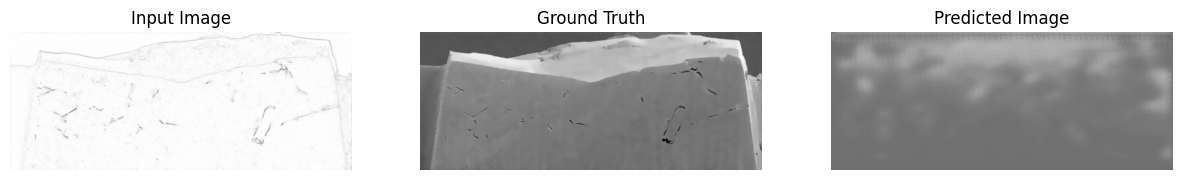

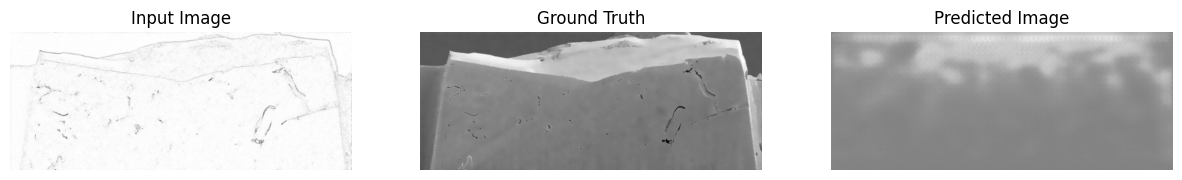

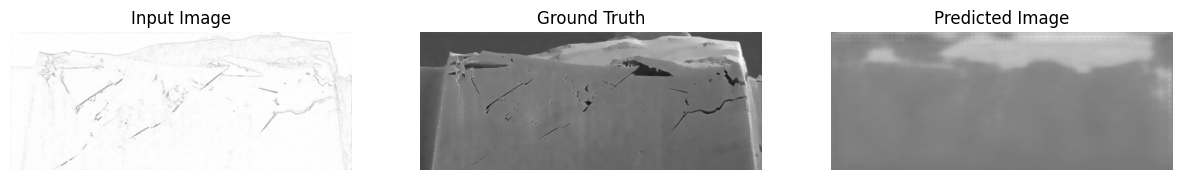

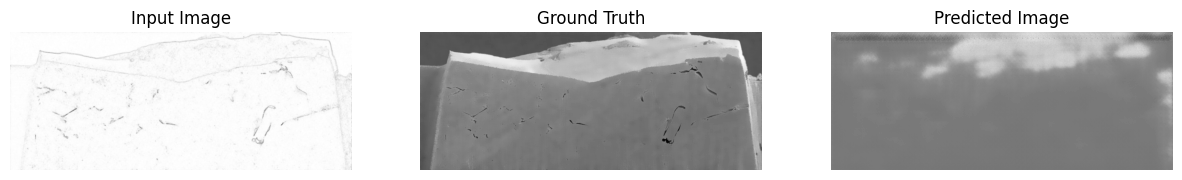

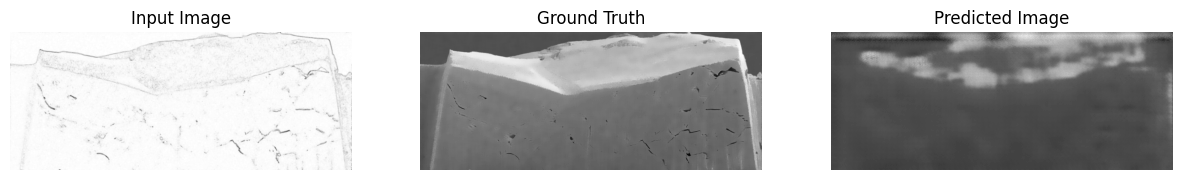

In [67]:
fit(train_dataset, 50, test_dataset)
#Canny inv dataset  - 80 - 50 - Normal Wieghts
#Canny inv erosion dataset - 80 - Normal weights

In [32]:
generator.save_weights(f'models/{dataset_name}_VT.h5')

## Canny

In [29]:
canny_model = Generator()
canny_model.load_weights("/teamspace/studios/this_studio/tensor-to-image/src/models/canny_100_50_VT.h5")

In [30]:
canny_test_images = os.listdir('/teamspace/studios/this_studio/canny/test')

In [ ]:
for image in canny_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/canny/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(canny_model, inp, re, 1000,f'{image}', dataset_name='canny', final=True)


## Canny Inverso

In [32]:
canny_inv_model = Generator()
canny_inv_model.load_weights("/teamspace/studios/this_studio/tensor-to-image/src/models/canny_inv_dataset_80_50_30_VT.h5")

In [33]:
canny_inv_test_images = os.listdir('/teamspace/studios/this_studio/canny_inv_dataset/test')

In [ ]:
for image in canny_inv_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/canny_inv_dataset/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(canny_inv_model, inp, re, 1000,f'{image}', dataset_name='canny_inv', final=True)


## Canny Inverso Erosion

In [35]:
canny_inv_erosion_model = Generator()
canny_inv_erosion_model.load_weights("/teamspace/studios/this_studio/tensor-to-image/src/models/canny_inv_erosion_dataset_80_50_30_VT.h5")

In [36]:
canny_inv_erosion_test_images = os.listdir('/teamspace/studios/this_studio/canny_inv_erosion_dataset/test')

In [ ]:
for image in canny_inv_erosion_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/canny_inv_erosion_dataset/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(canny_inv_erosion_model, inp, re, 1000,f'{image}', dataset_name='canny_inv_erosion', final=True)


## Laplaciano

In [38]:
laplaciano_model = Generator()
laplaciano_model.load_weights('/teamspace/studios/this_studio/tensor-to-image/src/models/laplaciano_100_50_VT.h5')

In [39]:
laplaciano_test_images = os.listdir('/teamspace/studios/this_studio/laplaciano/test')

In [ ]:
for image in laplaciano_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/laplaciano/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(laplaciano_model, inp, re, 1000,f'{image}', dataset_name='laplaciano', final=True)


## Laplacian Inv

In [41]:
laplaciano_inv_model = Generator()
laplaciano_inv_model.load_weights(f'/teamspace/studios/this_studio/tensor-to-image/src/models/laplaciano_inv_100_50_VT.h5')

In [42]:
laplaciano_inv_test_images = os.listdir('/teamspace/studios/this_studio/laplaciano_inv/test')

In [ ]:
for image in laplaciano_inv_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/laplaciano_inv/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(laplaciano_inv_model, inp, re, 1000,f'{image}', dataset_name='laplaciano_inv', final=True)


## Erosion Model

In [28]:
erosion_model = Generator()
erosion_model.load_weights('/teamspace/studios/this_studio/tensor-to-image/src/models/erosion_dilatacion_100_VT.h5')

In [29]:
erosion_test_images = os.listdir('/teamspace/studios/this_studio/erosion_dilatacion/test')

In [ ]:
for image in erosion_test_images:
    inp, re = load_image_test(f'/teamspace/studios/this_studio/erosion_dilatacion/test/{image}')

    inp = tf.expand_dims(inp, axis=0)
    
    re = tf.expand_dims(re, axis=0)

    generate_images(erosion_model, inp, re, 1000,f'{image}', dataset_name='laplaciano_inv_erosion', final=True)